# Answering Business Questions Using SQL

The purpose of this project is to practice answering questions using SQL queries. We will use a SQLite database ("chinook.db") which contains data from an online music store.

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Below, we define a few helper functions to streamline the process of querying our database using Python. We have also a diagram of the database schema for reference.

In [2]:
def run_query(q):
        with sqlite3.connect('chinook.db') as conn:
            return pd.read_sql(q, conn)

In [3]:
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)

In [4]:
def show_tables():
    with sqlite3.connect('chinook.db') as conn:
        q = '''
            SELECT
                name,
                type
            FROM sqlite_master
            WHERE type IN ("table", "view");
            '''
    return pd.read_sql(q, conn)

In [5]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


![Chinook Database Schema](chinook_schema.png)

In [6]:
usa_tracks_by_genre = '''
    WITH usa_tracks_sold AS
        (
        SELECT
            il.*,
            c.country
        FROM invoice_line il
        INNER JOIN invoice i ON i.invoice_id=il.invoice_id
        INNER JOIN customer c ON c.customer_id=i.customer_id
        WHERE c.country="USA"
        )
        
    SELECT
        g.name genre,
        COUNT(u.invoice_line_id) tracks_sold,
        CAST(COUNT(t.genre_id) AS FLOAT) / (SELECT COUNT(*) FROM usa_tracks_sold) percent_of_total
    FROM usa_tracks_sold u
    INNER JOIN track t ON t.track_id=u.track_id
    INNER JOIN genre g ON g.genre_id=t.genre_id
    GROUP BY genre
    ORDER BY tracks_sold DESC
    LIMIT 10
    '''
run_query(usa_tracks_by_genre)

,genre,tracks_sold,percent_of_total
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


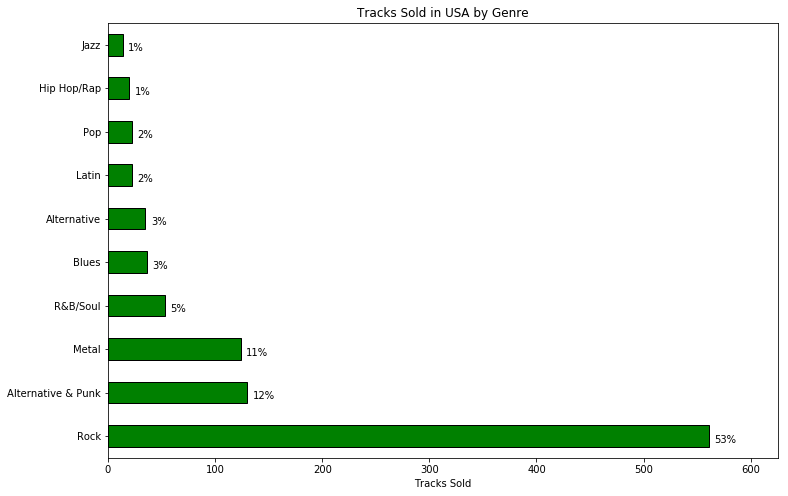

In [7]:
genre_sales_usa = run_query(usa_tracks_by_genre).set_index("genre")
ax = genre_sales_usa.plot(
    y='tracks_sold',
    kind='barh',
    figsize=(12,8),
    color='green',
    edgecolor='black',
    legend=False,
    xlim=(0,625))

plt.title("Tracks Sold in USA by Genre")
plt.xlabel("Tracks Sold")
plt.ylabel("")

for i, label in enumerate(list(genre_sales_usa.index)):
    score = genre_sales_usa.loc[label, "tracks_sold"]
    label = (genre_sales_usa.loc[label, "percent_of_total"] * 100).astype(int).astype(str) + "%"
    plt.annotate(label, (score + 5, i - 0.15))

plt.show()

Above, we identified the most popular genres for tracks sold in the USA. Rock is by far the most popular genre among our American customers, followed by Alternative & Punk and Metal. If we were considering carrying additional artists in our music store, artists of these genres would likely result in the most sales.

In [8]:
employee_total_sales = '''
    SELECT
        e.employee_id,
        e.first_name || " " || e.last_name employee_name,
        SUM(i.total) total_sales
        FROM employee e
        LEFT JOIN customer c ON c.support_rep_id=e.employee_id
        LEFT JOIN invoice i ON i.customer_id=c.customer_id
        GROUP BY employee_id
    '''
run_query(employee_total_sales)

,employee_id,employee_name,total_sales
0,1,Andrew Adams,NaN
1,2,Nancy Edwards,NaN
2,3,Jane Peacock,1731.51
3,4,Margaret Park,1584.00
4,5,Steve Johnson,1393.92
5,6,Michael Mitchell,NaN
6,7,Robert King,NaN
7,8,Laura Callahan,NaN


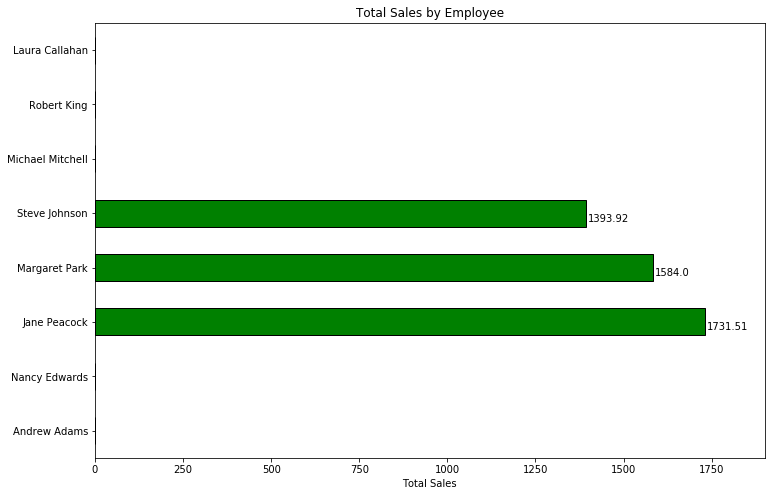

In [9]:
employee_sales = run_query(employee_total_sales).set_index("employee_name")
employee_sales['total_sales'].plot.barh(
    y='tracks_sold',
    figsize=(12,8),
    color='green',
    edgecolor='black',
    xlim=(0,1900))

plt.title("Total Sales by Employee")
plt.xlabel("Total Sales")
plt.ylabel("")

for i, label in enumerate(list(employee_sales.index)):
    score = employee_sales.loc[label, "total_sales"]
    plt.annotate(str(round(score,2)), (score + 5, i - 0.15))

plt.show()

Above, we have totaled the sales made by each of the music store's employees. Each customer is assigned a representative at the time they make a purchase. It appears that only three of eight employees have made any sales at all, with Jane Peacock making the most sales.

In [10]:
sales_by_country = '''
    WITH filter_countries AS
        (
         SELECT
             CASE
                 WHEN (
                       SELECT COUNT(*)
                       FROM customer
                       WHERE country = c.country
                       ) = 1 THEN "Other"
                 ELSE c.country
             END country,
             customer_id
         FROM customer c
        )
        
    SELECT
        country,
        customers,
        total_sales,
        average_order,
        customer_lifetime_value
    FROM
        (
        SELECT
            c.country country,
            COUNT(DISTINCT c.customer_id) customers,
            SUM(i.total) total_sales,
            SUM(i.total) / COUNT(DISTINCT c.customer_id) customer_lifetime_value,
            SUM(i.total) / COUNT(i.invoice_id) average_order,
            CASE
                WHEN c.country = "Other" THEN 1
                ELSE 0
            END sort
        FROM invoice i
        INNER JOIN filter_countries c ON c.customer_id=i.customer_id
        GROUP BY country
        ORDER BY sort ASC, total_sales DESC
        )
    '''
run_query(sales_by_country)

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


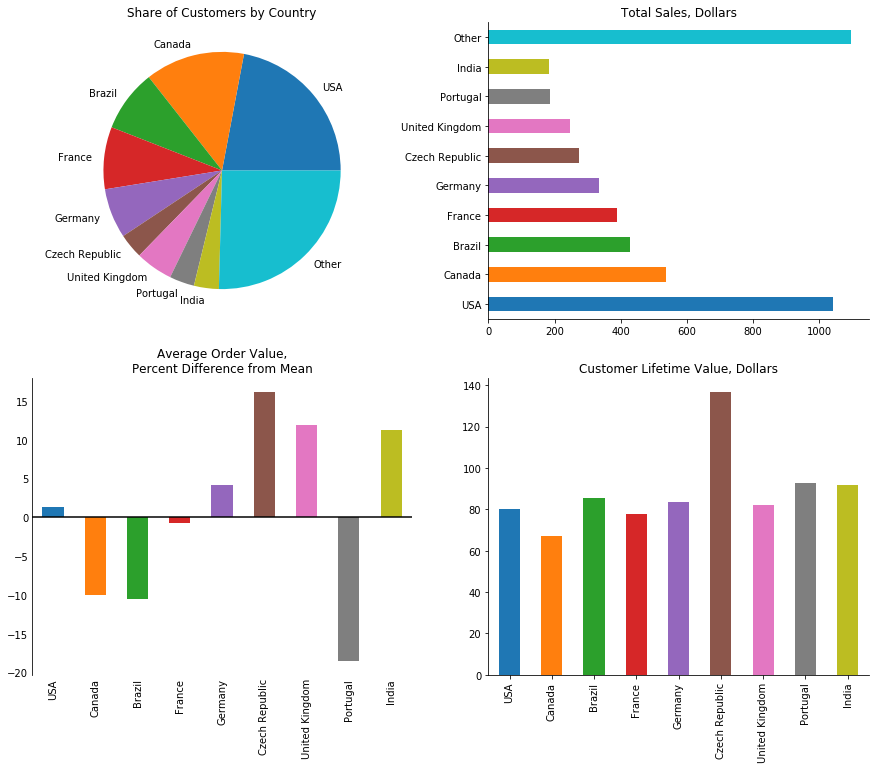

In [11]:
country_sales = run_query(sales_by_country).set_index("country")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(15,12))

# Top Left
country_sales['customers'].plot.pie(
    ax=ax1,
    cmap='tab10',
    legend=False,
    title="Share of Customers by Country"
    )
ax1.set_ylabel("")

# Top Right
country_sales['total_sales'].plot.barh(
    ax=ax2,
    color=plt.cm.tab10(np.arange(len(country_sales['total_sales']))),
    title="Total Sales, Dollars"
    )
ax2.set_xlabel("")
ax2.set_ylabel("")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

# Bottom Left
mean_order = country_sales['average_order'].mean()
pct_diff_from_mean = (country_sales['average_order'] - mean_order) / mean_order * 100
pct_diff_from_mean.iloc[0:9].plot.bar(
    ax=ax3,
    color=plt.cm.tab10(np.arange(len(country_sales['total_sales']))),
    title="Average Order Value,\nPercent Difference from Mean"
    )
ax3.set_ylabel("")
ax3.set_xlabel("")
ax3.axhline(0, color='black')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)
ax3.tick_params(length=0)

# Bottom Right
country_sales['customer_lifetime_value'].iloc[0:9].plot.bar(
    ax=ax4,
    color=plt.cm.tab10(np.arange(len(country_sales['total_sales']))),
    title="Customer Lifetime Value, Dollars"
    )
ax4.set_xlabel("")
ax4.set_ylabel("")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()

Above, we have compiled sales data by country (meaning the customer's home country). Because we had fifteen countries which only had one customer each, we grouped those countries in the "Other" category. As shown, customers in the USA comprise the largest share of music store customers, and also account for the greatest amount of total sales. However, customers from the Czech Republic tended to place the largest orders on average and spent the most per customer over their lifetime. It may be wise to increase marketing efforts in the Czech Republic to try to increase profits.

In [12]:
albums_vs_tracks = '''          
    SELECT
        il.invoice_id invoice_id,
        il.track_id track_id,
        a.album_id album_id
    FROM invoice_line il
    LEFT JOIN track t on t.track_id=il.track_id
    LEFT JOIN album a on a.album_id=t.album_id;
    
    '''
run_query(albums_vs_tracks)

,invoice_id,track_id,album_id
0,1,1158,91
1,1,1159,91
2,1,1160,91
3,1,1161,91
4,1,1162,91
5,1,1163,91
6,1,1164,91
7,1,1165,91
8,1,1166,91
9,1,1167,91


In [13]:
albums_vs_tracks = '''      
    SELECT
        a.album_id album_id,
        t.track_id track_id
    FROM
        track t
    LEFT JOIN album a on a.album_id=t.album_id;
    
    '''
run_query(albums_vs_tracks)

,album_id,track_id
0,1,1
1,1,6
2,1,7
3,1,8
4,1,9
5,1,10
6,1,11
7,1,12
8,1,13
9,1,14


In [14]:
albums_vs_tracks = '''      
    WITH invoice_first_track AS
        (
         SELECT
             il.invoice_id invoice_id,
             MIN(il.track_id) first_track_id
         FROM invoice_line il
         GROUP BY 1
        )
        
    SELECT
        album_purchase,
        COUNT(invoice_id) number_of_invoices,
        CAST(COUNT(invoice_id) AS FLOAT) / (
                                            SELECT COUNT(*)
                                            FROM invoice
                                           ) percent
    FROM
        (
         SELECT
             ifs.*,
             CASE
                 WHEN
                     (
                      SELECT t.track_id
                      FROM track t
                      WHERE t.album_id = (
                                          SELECT t2.album_id
                                          FROM track t2
                                          WHERE t2.track_id=ifs.first_track_id
                                         )
                      EXCEPT
                  
                      SELECT il2.track_id
                      FROM invoice_line il2
                      WHERE il2.invoice_id=ifs.invoice_id
                     ) IS NULL
                AND
                     (
                      SELECT il2.track_id
                      FROM invoice_line il2
                      WHERE il2.invoice_id=ifs.invoice_id
                  
                      EXCEPT
                  
                      SELECT t.track_id
                      FROM track t
                      WHERE t.album_id = (
                                          SELECT t2.album_id
                                          FROM track t2
                                          WHERE t2.track_id=ifs.first_track_id
                                         )
                     ) IS NULL
                THEN "yes"
                ELSE "no"
            END AS album_purchase
        FROM invoice_first_track ifs
            )
    GROUP BY album_purchase
    '''
run_query(albums_vs_tracks)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


In this final step, we determined the percentage of purchases which were comprised of full albums vs. individual tracks. The way our music store is set up, customers can either purchase an entire album, or select individual tracks from various albums. We determined that about 81% of purchases were comprised of individually selected tracks, while 19% of purchases consisted of complete albums.